# **Problem**: 
Detect and classify seizures and other types of harmful brain activity. Build model trained on electroencephalography (EEG) signals recorded from critically ill hospital patients.

Classification Models:
- CNN : convolutional neural net to classify the 4 types of seizures*

# Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import math
import itertools
import matplotlib.pyplot as plt
from matplotlib import colormaps

#Preprocessing
import tensorflow as tf
from tensorflow import keras

# EDA

# 1. Data exploration
- Spectograms: are samples of 5 minutes, 300 rows in total. There are 4 chars: LL, RL, RP, LP. Each column of train_spectograms corresponds to a level of LL/RP/RL/LP over time
- EEGS

In [2]:
df_eegs = pd.read_parquet('/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/1001369401.parquet', engine='pyarrow')
df_spec = pd.read_parquet('/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/1000086677.parquet', engine='pyarrow')
df_train = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')

eeg_ids = df_train['eeg_id'].unique()
spec_ids = df_train['spectrogram_id'].unique()

In [3]:
class Data:
    
    '''class to manipulate data faster'''
    
    def __init__(self):
        self.base_dir = '/kaggle/input/hms-harmful-brain-activity-classification/'
        
    def get_train_eegs(self, eeg_id):
        path = self.base_dir+'train_eegs/'+f'{eeg_id}.parquet'
        df = pd.read_parquet(path)
        return df
    
    def get_train_spec(self, spec_id):
        path = self.base_dir+'train_spectrograms/'+f'{spec_id}.parquet'
        df = pd.read_parquet(path)
        return df
    
class DatasetBuilder:
    '''Class in charge of making the training set.'''
    def build_training_set(self):
        pass
    
tool = Data()
eeg = tool.get_train_eegs(1628180742)
spec_1 = tool.get_train_spec(1000757705)
spec_2 = tool.get_train_spec(1000189855) #each column is the position at which the sensor is located. Values are the intensity of the signal... i guess
unique_labels = set([i.split("_")[0] for i in spec_1.columns])
unique_labels


{'LL', 'LP', 'RL', 'RP', 'time'}

## 1. Ploting Spectogram

In [4]:

mask_ll, mask_lp, mask_rl, mask_rp = (
    [i for i in spec_1.columns if "LL" in i],
    [i for i in spec_1.columns if "LP" in i],
    [i for i in spec_1.columns if "RL" in i],
    [i for i in spec_1.columns if "RP" in i]
)
sensors = (LL, LP, RL, RP) = spec_1[mask_ll],spec_1[mask_lp], spec_1[mask_rl], spec_1[mask_rp]

In [5]:
list(colormaps)

['magma',
 'inferno',
 'plasma',
 'viridis',
 'cividis',
 'twilight',
 'twilight_shifted',
 'turbo',
 'Blues',
 'BrBG',
 'BuGn',
 'BuPu',
 'CMRmap',
 'GnBu',
 'Greens',
 'Greys',
 'OrRd',
 'Oranges',
 'PRGn',
 'PiYG',
 'PuBu',
 'PuBuGn',
 'PuOr',
 'PuRd',
 'Purples',
 'RdBu',
 'RdGy',
 'RdPu',
 'RdYlBu',
 'RdYlGn',
 'Reds',
 'Spectral',
 'Wistia',
 'YlGn',
 'YlGnBu',
 'YlOrBr',
 'YlOrRd',
 'afmhot',
 'autumn',
 'binary',
 'bone',
 'brg',
 'bwr',
 'cool',
 'coolwarm',
 'copper',
 'cubehelix',
 'flag',
 'gist_earth',
 'gist_gray',
 'gist_heat',
 'gist_ncar',
 'gist_rainbow',
 'gist_stern',
 'gist_yarg',
 'gnuplot',
 'gnuplot2',
 'gray',
 'hot',
 'hsv',
 'jet',
 'nipy_spectral',
 'ocean',
 'pink',
 'prism',
 'rainbow',
 'seismic',
 'spring',
 'summer',
 'terrain',
 'winter',
 'Accent',
 'Dark2',
 'Paired',
 'Pastel1',
 'Pastel2',
 'Set1',
 'Set2',
 'Set3',
 'tab10',
 'tab20',
 'tab20b',
 'tab20c',
 'magma_r',
 'inferno_r',
 'plasma_r',
 'viridis_r',
 'cividis_r',
 'twilight_r',
 'twilight

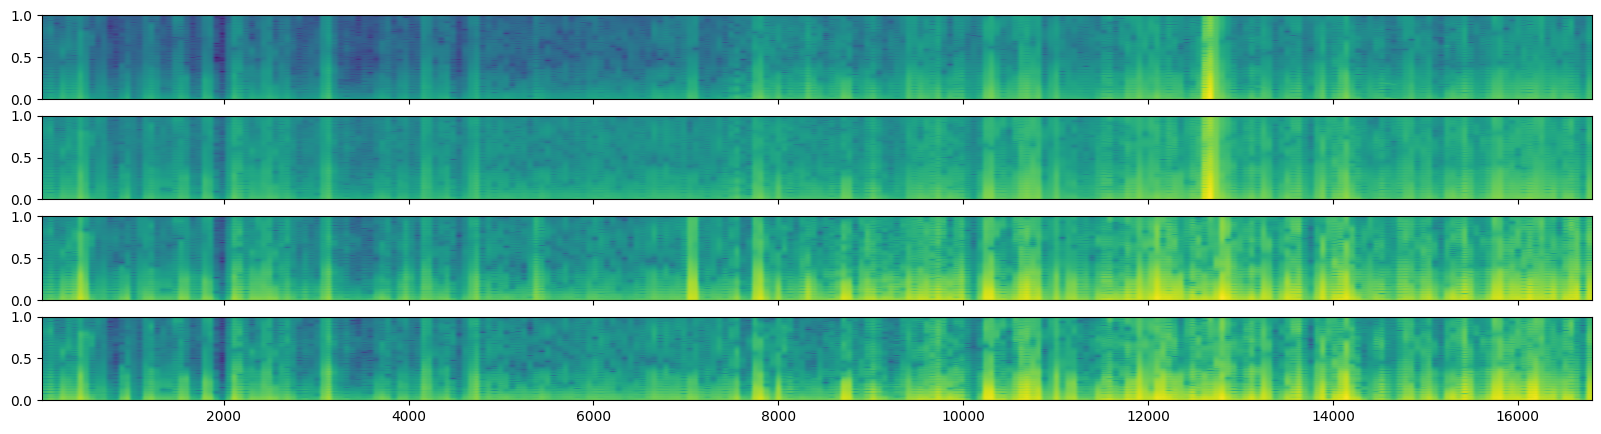

In [6]:
fig, axs = plt.subplots(4,1, sharex = True,sharey=True,figsize=(20,5))
for ax, sensor in enumerate(sensors):
    axs[ax].specgram(sensor.values.flatten(), cmap='viridis')

2. Data Trandformation:
- 1st: use the train .csv as an index to build the spectogram images.
- 2nd: take the train dataframe and append an insert image